# Описание

В общей системе экспериментальной установки нам необходимо подготовить модель сети связи на которую будут наложены сетевые задержки в рамках LWMECPS используя Litmus Chaos. 

Алгоритм HCPP на базе стохастической геометрии позволяет при определенном приближении расчитать сеть связи в двухмерном пространстве.

<Figure size 1000x1000 with 0 Axes>

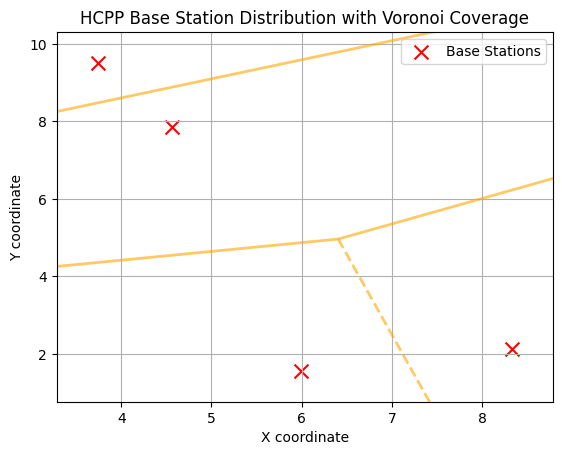

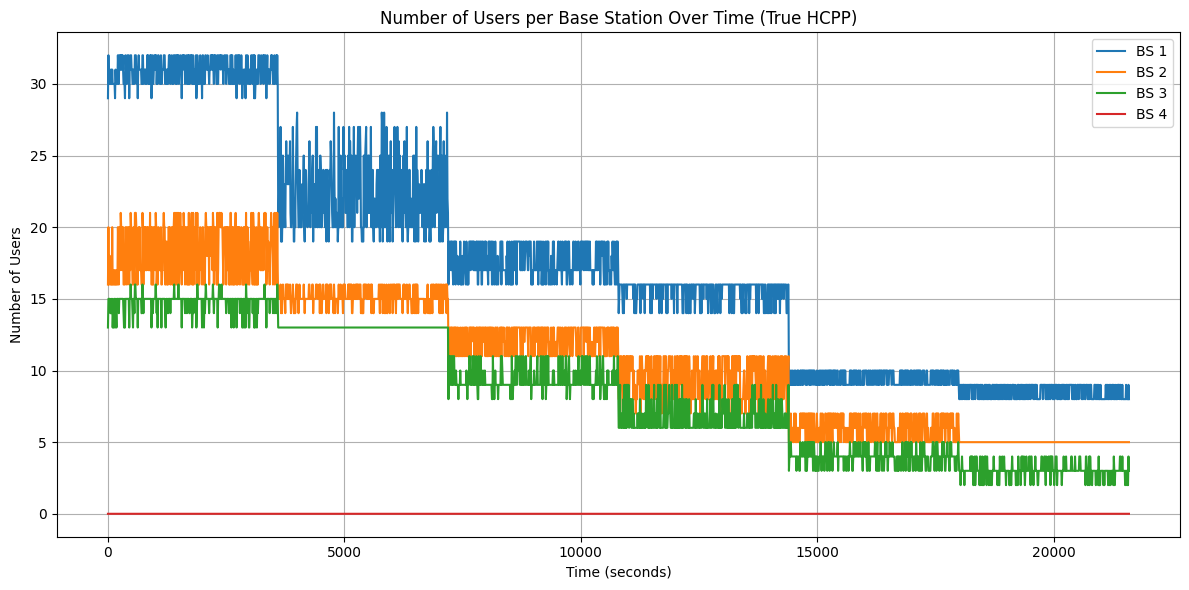

{'bs_1': [{'host': 'lwmecps-testapp-server-bs1', 'port': 8000}, {'host': 'lwmecps-testapp-server-bs2', 'port': 8000}, {'host': 'lwmecps-testapp-server-bs3', 'port': 8000}, {'host': 'lwmecps-testapp-server-bs4', 'port': 8000}], 'bs_2': [{'host': 'lwmecps-testapp-server-bs2', 'port': 8000}, {'host': 'lwmecps-testapp-server-bs3', 'port': 8000}, {'host': 'lwmecps-testapp-server-bs4', 'port': 8000}, {'host': 'lwmecps-testapp-server-bs1', 'port': 8000}], 'bs_3': [{'host': 'lwmecps-testapp-server-bs3', 'port': 8000}, {'host': 'lwmecps-testapp-server-bs4', 'port': 8000}, {'host': 'lwmecps-testapp-server-bs1', 'port': 8000}, {'host': 'lwmecps-testapp-server-bs2', 'port': 8000}], 'bs_4': [{'host': 'lwmecps-testapp-server-bs4', 'port': 8000}, {'host': 'lwmecps-testapp-server-bs1', 'port': 8000}, {'host': 'lwmecps-testapp-server-bs2', 'port': 8000}, {'host': 'lwmecps-testapp-server-bs3', 'port': 8000}]}
{'bs_1': [{'host': 'lwmecps-testapp-server-bs1', 'port': 8000}, {'host': 'lwmecps-testapp-serve

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import json
from collections import defaultdict
import os

class TrueHCPPNetwork:
    def __init__(self, area_size=100, num_base_stations=50,
                 min_distance=10, intensity_lambda=1.0, beta=1.0, num_users=200):
        """
        Реализация настоящего HCPP (Hard-Core Point Process)

        Args:
        - area_size: размер территории
        - num_base_stations: число базовых станций
        - min_distance: минимальное расстояние между станциями
        - intensity_lambda: параметр интенсивности процесса
        - beta: параметр взаимодействия
        - num_users: число пользователей
        """
        self.area_size = area_size
        self.num_base_stations = num_base_stations
        self.min_distance = min_distance
        self.intensity_lambda = intensity_lambda
        self.beta = beta
        self.num_users = num_users
        
        self.base_stations = None
        self.users = None
        self.connectivity_matrix = None
        self.graph = None

    def intensity_function(self, x):
        """
        Функция интенсивности λ(x)
        """
        return self.intensity_lambda

    def interaction_function(self, x, y):
        """
        Функция взаимодействия h(x,y)
        """
        distance = np.linalg.norm(x - y)
        if distance < self.min_distance:
            return 0
        return np.exp(-self.beta * distance)

    def calculate_density(self, points):
        """
        Расчет плотности вероятности для множества точек
        """
        if len(points) == 0:
            return 1.0

        # Произведение функций интенсивности
        intensity_product = np.prod([self.intensity_function(p) for p in points])
        
        # Произведение функций взаимодействия
        interaction_product = 1.0
        for i in range(len(points)):
            for j in range(i + 1, len(points)):
                interaction_product *= self.interaction_function(points[i], points[j])
        
        return intensity_product * interaction_product

    def generate_base_stations(self, fixed_seed=None, num_iterations=1000):
        """
        Генерация базовых станций с использованием алгоритма Метрополиса-Гастингса
        """
        if fixed_seed is not None:
            np.random.seed(fixed_seed)

        # Начальное состояние - пустое множество точек
        current_points = []
        current_density = self.calculate_density(current_points)
        
        for _ in range(num_iterations):
            # Предлагаем новую точку
            new_point = np.random.uniform(0, self.area_size, 2)
            
            # Проверяем минимальное расстояние
            if any(np.linalg.norm(new_point - p) < self.min_distance for p in current_points):
                continue
                
            # Создаем новое множество точек
            proposed_points = current_points + [new_point]
            proposed_density = self.calculate_density(proposed_points)
            
            # Принимаем или отвергаем новую точку
            acceptance_ratio = proposed_density / current_density if current_density > 0 else float('inf')
            if np.random.random() < min(1, acceptance_ratio):
                current_points = proposed_points
                current_density = proposed_density
                
            # Останавливаемся, если достигли нужного количества точек
            if len(current_points) >= self.num_base_stations:
                break
        
        self.base_stations = np.array(current_points)
        return self.base_stations

    def generate_users(self, ue_count, base_stations=None, distribution='uniform', fixed_seed=None):
        """
        Генерация пользователей с различными распределениями
        Args:
        - ue_count: количество пользователей
        - base_stations: координаты базовых станций (для кластерного распределения)
        - distribution: тип распределения ('uniform', 'normal', 'clustered')
        - fixed_seed: фиксированное значение для генератора случайных чисел
        Returns:
        - Массив координат пользователей
        """
        if fixed_seed is not None:
            np.random.seed(fixed_seed)
        area_size = 100  # Можно сделать параметром класса, если нужно
        if distribution == 'uniform':
            return np.random.uniform(0, area_size, (ue_count, 2))
        elif distribution == 'normal':
            center = np.array([area_size/2, area_size/2])
            return np.random.normal(center, scale=10, size=(ue_count, 2))
        elif distribution == 'clustered' and base_stations is not None:
            clusters = base_stations
            users = []
            for i in range(ue_count):
                cluster = clusters[np.random.randint(len(clusters))]
                users.append(np.random.normal(cluster, scale=5, size=2))
            return np.array(users)
        else:
            return np.random.uniform(0, area_size, (ue_count, 2))

    def visualize_distribution(self):
        """
        Визуализация распределения базовых станций
        """
        if self.base_stations is None:
            raise ValueError("Base stations not generated yet")

        plt.figure(figsize=(10, 10))
        
        # Создаем диаграмму Вороного
        vor = Voronoi(self.base_stations)
        voronoi_plot_2d(vor, show_vertices=False, line_colors='orange', 
                       line_width=2, line_alpha=0.6, point_size=0)
        
        # Отображаем базовые станции
        plt.scatter(self.base_stations[:, 0], self.base_stations[:, 1], 
                   c='red', marker='x', s=100, label='Base Stations')
        
        if self.users is not None:
            plt.scatter(self.users[:, 0], self.users[:, 1], 
                       alpha=0.5, s=10, label='Users')
        
        plt.title('HCPP Base Station Distribution with Voronoi Coverage')
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
        plt.legend()
        plt.grid(True)
        plt.show()

class TrueLoadProfileUserDistribution:
    def __init__(self, load_profile_path, num_base_stations):
        """
        Инициализация распределения пользователей на основе профиля нагрузки
        Args:
        - load_profile_path: путь к JSON файлу с профилем нагрузки
        - num_base_stations: количество базовых станций
        """
        self.load_profile_path = load_profile_path
        self.num_base_stations = num_base_stations
        self.load_profile = None
        self.load_profile_data()

    def generate_users(self, ue_count, base_stations=None, distribution='clustered', fixed_seed=None):
        """
        Генерация пользователей с различными распределениями
        Args:
        - ue_count: количество пользователей
        - base_stations: координаты базовых станций (для кластерного распределения)
        - distribution: тип распределения ('uniform', 'normal', 'clustered')
        - fixed_seed: фиксированное значение для генератора случайных чисел
        Returns:
        - Массив координат пользователей
        """
        if fixed_seed is not None:
            np.random.seed(fixed_seed)
        area_size = 100  # Можно сделать параметром класса, если нужно
        if distribution == 'uniform':
            return np.random.uniform(0, area_size, (ue_count, 2))
        elif distribution == 'normal':
            center = np.array([area_size/2, area_size/2])
            return np.random.normal(center, scale=10, size=(ue_count, 2))
        elif distribution == 'clustered' and base_stations is not None:
            clusters = base_stations
            users = []
            for i in range(ue_count):
                cluster = clusters[np.random.randint(len(clusters))]
                users.append(np.random.normal(cluster, scale=5, size=2))
            return np.array(users)
        else:
            return np.random.uniform(0, area_size, (ue_count, 2))

    def load_profile_data(self):
        """Загрузка данных профиля нагрузки"""
        with open(self.load_profile_path, 'r') as f:
            self.load_profile = json.load(f)

    def get_ue_count_at_time(self, time_index):
        """Получение количества UE в определенный момент времени"""
        if time_index < len(self.load_profile):
            return {
                'ue_count': self.load_profile[time_index]['ue_count'],
                'timestamp': self.load_profile[time_index]['timestamp']
            }
        return None
    # Тут распределение пользователей по базовым станциям на основе профиля нагрузки
    def distribute_users(self, time_index, base_stations, fixed_seed=None, distribution='clustered'):
        """
        Распределение пользователей по базовым станциям на основе профиля нагрузки
        Args:
        - time_index: индекс времени в профиле нагрузки
        - base_stations: координаты базовых станций
        - fixed_seed: фиксированное значение для генератора случайных чисел
        - distribution: тип распределения пользователей ('uniform', 'normal', 'clustered')
        Returns:
        - Словарь с распределением пользователей по станциям, timestamp
        """
        time_data = self.get_ue_count_at_time(time_index)
        if time_data is None:
            return None, None
        ue_count = time_data['ue_count']
        timestamp = time_data['timestamp']
        user_distribution = defaultdict(list)
        if fixed_seed is not None:
            np.random.seed(fixed_seed + time_index)
        # Генерируем пользователей с указанным распределением
        users = self.generate_users(ue_count, base_stations, distribution=distribution, fixed_seed=fixed_seed)
        for user_pos in users:
            distances = np.linalg.norm(base_stations - user_pos, axis=1)
            nearest_station = np.argmin(distances)
            user_distribution[nearest_station].append(user_pos.tolist())
        return user_distribution, timestamp

    def visualize_distribution(self, time_index, base_stations, distribution):
        """Визуализация распределения пользователей"""
        plt.figure(figsize=(12, 10))
        vor = Voronoi(base_stations)
        voronoi_plot_2d(vor, show_vertices=False, line_colors='orange', 
                       line_width=2, line_alpha=0.6, point_size=0)
        plt.scatter(base_stations[:, 0], base_stations[:, 1], 
                   c='red', marker='x', s=100, label='Base Stations')
        for station_idx, users in distribution.items():
            if users:
                users = np.array(users)
                plt.scatter(users[:, 0], users[:, 1], 
                          alpha=0.5, s=10, 
                          label=f'Users on Station {station_idx}')
        plt.title(f'User Distribution with Voronoi Coverage at Time Index {time_index}')
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
        plt.legend()
        plt.grid(True)
        plt.show()

    def calculate_coverage_statistics(self, base_stations, distribution):
        """
        Расчет статистики покрытия на основе диаграммы Вороного
        Returns: словарь со статистикой покрытия для каждой станции
        """
        vor = Voronoi(base_stations)
        coverage_stats = {}
        for station_idx, users in distribution.items():
            if users:
                users = np.array(users)
                region_idx = vor.point_region[station_idx]
                region = vor.regions[region_idx]
                inside_cell = []
                for user in users:
                    if self._point_in_polygon(user, vor.vertices[region]):
                        inside_cell.append(user)
                coverage_stats[station_idx] = {
                    'total_users': len(users),
                    'users_in_cell': len(inside_cell),
                    'coverage_percentage': (len(inside_cell) / len(users)) * 100 if len(users) > 0 else 0
                }
        return coverage_stats

    def _point_in_polygon(self, point, polygon):
        """
        Проверка, находится ли точка внутри многоугольника
        """
        x, y = point
        n = len(polygon)
        inside = False
        p1x, p1y = polygon[0]
        for i in range(1, n + 1):
            p2x, p2y = polygon[i % n]
            if y > min(p1y, p2y):
                if y <= max(p1y, p2y):
                    if x <= max(p1x, p2x):
                        if p1y != p2y:
                            xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                        if p1x == p2x or x <= xinters:
                            inside = not inside
            p1x, p1y = p2x, p2y
        return inside

    def save_station_profiles(self, base_stations, domain_mapping=None, output_dir='.'):
        """
        Сохраняет профиль нагрузки для каждой базовой станции в отдельный JSON-файл.
        Args:
            base_stations: координаты базовых станций
            domain_mapping: словарь {индекс: доменное имя} (опционально)
            output_dir: директория для сохранения файлов
        """
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        for station_idx in range(1, len(base_stations) + 1):
            all_load_profiles = []
            for time_index in range(len(self.load_profile)):
                # Получаем распределение пользователей для текущего момента времени
                distribution, timestamp = self.distribute_users(time_index, base_stations)
                if distribution is None:
                    continue
                # Определяем интервал между временными точками
                if time_index < len(self.load_profile) - 1:
                    next_timestamp = self.load_profile[time_index + 1]['timestamp']
                else:
                    next_timestamp = timestamp + 10  # по умолчанию 10 секунд
                interval = next_timestamp - timestamp
                # Формируем профиль нагрузки
                profile = {
                    "concurrent_users": len(distribution[station_idx]),
                    "request_interval": interval,
                    "profile_duration": interval
                }
                all_load_profiles.append(profile)
            # Формируем структуру профиля для БС
            print(domain_mapping)
            station_profile = {
                "id": f"bs_{station_idx}",
                "name": f"Base Station {station_idx}",
                # Тут можно поменять timeout
                "timeout": 0.4,
                "settings": {
                    # Тут можно поменять IP
                    "hosts": domain_mapping[f"bs_{station_idx}"] if domain_mapping else f"bs_{station_idx}.local",
                    "port": 8000,
                    "load_profiles": all_load_profiles
                }
            }
            # Сохраняем в файл
            file_path = os.path.join(output_dir, f"bs_{station_idx}_profile.json")
            with open(file_path, 'w') as f:
                json.dump(station_profile, f, indent=4)

def plot_users_per_station_over_time(network, load_profile_dist, base_stations, fixed_seed=None):
    """
    Строит график количества пользователей по каждой базовой станции во времени
    network: экземпляр TrueHCPPNetwork
    load_profile_dist: экземпляр TrueLoadProfileUserDistribution
    base_stations: координаты базовых станций
    fixed_seed: фиксированный seed для воспроизводимости
    """
    timestamps = [step['timestamp'] for step in load_profile_dist.load_profile]
    num_stations = network.num_base_stations
    plt.figure(figsize=(12, 6))
    for station_idx in range(1, num_stations + 1):
        users_over_time = []
        for time_index in range(len(load_profile_dist.load_profile)):
            distribution, _ = load_profile_dist.distribute_users(time_index, base_stations, fixed_seed=fixed_seed)
            users_over_time.append(len(distribution[station_idx]))
        plt.plot(timestamps, users_over_time, label=f'BS {station_idx}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Number of Users')
    plt.title('Number of Users per Base Station Over Time (True HCPP)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Создаем сеть с HCPP
    hcpp_network = TrueHCPPNetwork(
        area_size=10,
        num_base_stations=4,
        min_distance=1,
        intensity_lambda=1.0,
        beta=0.1,
        num_users=100  # задаем количество пользователей
    )
    base_stations = hcpp_network.generate_base_stations(fixed_seed=42)
    # Генерируем пользователей
    users = hcpp_network.generate_users(hcpp_network.num_users, distribution='uniform', fixed_seed=123)
    # Визуализируем распределение базовых станций и пользователей
    hcpp_network.visualize_distribution()

    # Используем реальный профиль нагрузки
    load_profile_path = '../test_env/load_profile_with_deviation.json'
    load_dist = TrueLoadProfileUserDistribution(load_profile_path, num_base_stations=4)

    # Строим график
    plot_users_per_station_over_time(hcpp_network, load_dist, base_stations, fixed_seed=123)


    hosts = {
        'bs_1': [
            {'host': 'lwmecps-testapp-server-bs1', 'port': 8000},
            {'host': 'lwmecps-testapp-server-bs2', 'port': 8000},
            {'host': 'lwmecps-testapp-server-bs3', 'port': 8000},
            {'host': 'lwmecps-testapp-server-bs4', 'port': 8000}
        ],
        'bs_2': [
            {'host': 'lwmecps-testapp-server-bs2', 'port': 8000},
            {'host': 'lwmecps-testapp-server-bs3', 'port': 8000},
            {'host': 'lwmecps-testapp-server-bs4', 'port': 8000},
            {'host': 'lwmecps-testapp-server-bs1', 'port': 8000}
        ],
        'bs_3': [
            {'host': 'lwmecps-testapp-server-bs3', 'port': 8000},
            {'host': 'lwmecps-testapp-server-bs4', 'port': 8000},
            {'host': 'lwmecps-testapp-server-bs1', 'port': 8000},
            {'host': 'lwmecps-testapp-server-bs2', 'port': 8000}

        ],
        'bs_4': [
            {'host': 'lwmecps-testapp-server-bs4', 'port': 8000},
            {'host': 'lwmecps-testapp-server-bs1', 'port': 8000},
            {'host': 'lwmecps-testapp-server-bs2', 'port': 8000},
            {'host': 'lwmecps-testapp-server-bs3', 'port': 8000}
        ]
    }

    # Create domain mapping for base stations
    # domain_mapping = {i: [host['host'] for host in station_hosts] 
    #                 for i, station_hosts in enumerate(hosts.values())}
    domain_mapping=hosts

    # Сохраняем профили нагрузки для каждой БС
    load_dist.save_station_profiles(base_stations, domain_mapping=domain_mapping, output_dir="profiles")
    print("Профили нагрузки для каждой базовой станции сохранены в папке 'profiles'.") 